# CALCULATE WINTIME COEFFICIENTS

## Outline
The goal of this notebook is to calculate coefficients for the effect on wintimes of:
+ distance
+ going
+ raceclass
+ age_conditions

In [52]:
# set up, imports and configuration
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
# plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

## Get The Data

In [53]:
# Read wintimes from csv file
wintimes = pd.read_csv("/home/benjamin/Documents/form_study/analysis/deepmine/csv/wintimes.csv")
len(wintimes)

170727

## Clean The Data

In [54]:
wintimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170727 entries, 0 to 170726
Data columns (total 11 columns):
Unnamed: 0    170727 non-null int64
raceID        170727 non-null float64
racedate      170727 non-null object
racecourse    170727 non-null float64
distance      170727 non-null float64
going         170727 non-null object
raceclass     136046 non-null float64
racetype      170727 non-null object
racetype2     170727 non-null object
age_cond      170727 non-null object
wintime       170581 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 14.3+ MB


In [55]:
# drop nas
wintimes = wintimes.dropna(subset=['wintime'], how='any')
wintimes = wintimes.dropna(subset=['raceclass'], how='any')

In [56]:
# convert going to a numbered dict
goingDict = {'fast': 1, 'firm': 2, 'good-firm': 3, 'standard': 4, 'good': 5, 'good-soft': 6, 'soft': 7 , 'slow': 8, 'heavy': 9 }
wintimes = wintimes.replace({"going": goingDict})

In [57]:
# convert racetype2 to a numbered dict
wintimes.racetype2.value_counts()
type2dict = {'Flat': 1, 'Hurdle': 2, 'Chase' : 3, 'National Hunt Flat' : 4}
wintimes = wintimes.replace({"racetype2": type2dict})

In [58]:
# reduce number of age_conditions categories
age_cond_dict = {'9yo+': 'N/A', '2yo+': 'N/A', '0yo+': 'N/A', '7yo+' : 'N/A', '8yo' : 'N/A', '8yo+': 'N/A',
                '4yo': '4yo+', '6yo+': '4yo+', '5yo': '4yo+', '5yo+': '4yo+'}
wintimes = wintimes.replace({"age_cond": age_cond_dict})
wintimes = wintimes.drop(wintimes[wintimes.age_cond=='N/A'].index)
# convert age conditions to a numbered dict
age_cond_dict = {'2yo': 1, '3yo': 2, '4yo+' : 3, '3yo+': 4}
wintimes = wintimes.replace({"age_cond": age_cond_dict})
wintimes.age_cond.value_counts()

3    66090
4    32972
2    19921
1    16864
Name: age_cond, dtype: int64

In [59]:
# Fairly simple to convert the race dates to pandas datetime format 
wintimes['racedate'] = pd.to_datetime(wintimes['racedate'])

In [60]:
# Drop some columns
wintimes.drop(['raceID','racetype'], axis=1, inplace=True)

In [61]:
wintimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135847 entries, 0 to 170718
Data columns (total 9 columns):
Unnamed: 0    135847 non-null int64
racedate      135847 non-null datetime64[ns]
racecourse    135847 non-null float64
distance      135847 non-null float64
going         135847 non-null int64
raceclass     135847 non-null float64
racetype2     135847 non-null int64
age_cond      135847 non-null int64
wintime       135847 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 10.4 MB


In [62]:
wintimes.describe()

,Unnamed: 0,racecourse,distance,going,raceclass,racetype2,age_cond,wintime
count,135847.000000,135847.000000,135847.000000,135847.00000,135847.000000,135847.000000,135847.000000,135847.000000
mean,46837.747098,33.116889,12.773185,4.91274,4.386354,1.600492,2.847792,182.280634
std,27888.554717,17.930947,6.465887,2.07985,1.355963,0.852141,0.928846,108.645168
min,0.000000,1.000000,5.000000,1.00000,1.000000,1.000000,1.000000,0.010000
25%,22594.000000,19.000000,7.000000,3.00000,4.000000,1.000000,2.000000,87.490000
50%,46626.000000,33.000000,10.400000,5.00000,5.000000,1.000000,3.000000,138.510000
75%,69957.000000,48.000000,17.000000,6.00000,5.000000,2.000000,3.000000,263.970000
max,131798.000000,222.000000,36.000000,9.00000,7.000000,4.000000,4.000000,660.060000


In [63]:
wintimes.head()

,Unnamed: 0,racedate,racecourse,distance,going,raceclass,racetype2,age_cond,wintime
0,0,2000-01-15,1.0,20.0,6,3.0,2,3,324.91
1,7,2000-01-15,1.0,19.5,6,2.0,3,3,309.59
2,12,2000-01-15,1.0,16.0,6,1.0,3,3,244.63
3,22,2000-01-15,1.0,16.5,6,2.0,2,3,255.31
4,29,2000-01-15,1.0,24.5,6,2.0,3,3,398.33


In [64]:
len(wintimes)

135847

## Remove Outliers
My useful remove outliers method from part one.

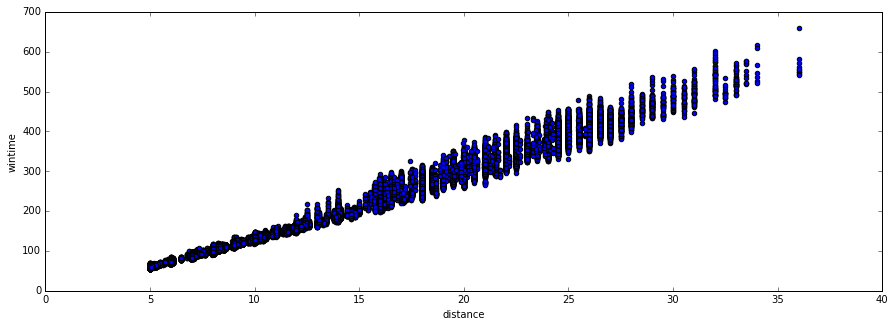

In [65]:
# er... I'm not really sure how this fantastic code I wrote previously really works
# but anyway... it removes 2000 odd outlier races from 135,000 races
# I'll go with it
statsdf = wintimes.groupby(['racecourse','racetype2','distance']).wintime.agg(['mean', 'std','count']).reset_index()
wintimes = pd.merge(wintimes, statsdf, how='left', on=['racecourse','racetype2','distance'])
wintimes = wintimes.dropna(subset=['mean', 'std', 'wintime', 'count'], how='any')
wintimes['stdx3'] = wintimes['std'] * 3
wintimes['windiff'] = abs(wintimes['wintime'] - wintimes['mean'])
wintimes = wintimes[wintimes.windiff < wintimes.stdx3]
wintimes.drop(['windiff','stdx3','mean','std'], axis=1, inplace=True)
wintimes = wintimes[(wintimes['count'] > 5)]
wintimes.plot(kind='scatter', x='distance', y='wintime')

In [66]:
len(wintimes)

133850

In [67]:
wintimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133850 entries, 0 to 135846
Data columns (total 10 columns):
Unnamed: 0    133850 non-null int64
racedate      133850 non-null datetime64[ns]
racecourse    133850 non-null float64
distance      133850 non-null float64
going         133850 non-null int64
raceclass     133850 non-null float64
racetype2     133850 non-null int64
age_cond      133850 non-null int64
wintime       133850 non-null float64
count         133850 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 11.2 MB


In [68]:
# I'll write to a new csv file here
wintimes.to_csv("/home/benjamin/Documents/form_study/analysis/deepmine/csv/clean_wintimes_3.csv")

## Calculate the Mean Wintimes For Races Under Identical Race Conditions

While this proved the wrong thing to do for these purposes it may be  useful code and data for composing speed ratings in the future.

In [69]:
# set up, imports and configuration again in case I run it from here
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
# plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [70]:
# If I read in the new csv file I can run the notebook on preprocessed (cleaned) data from here
wintimes = pd.read_csv("/home/benjamin/Documents/form_study/analysis/deepmine/csv/clean_wintimes_3.csv")
len(wintimes)

133850

In [71]:
# I split the wintimes into different dataframes based on racetype
flt_times = wintimes[wintimes.racetype2 == 1]
chs_times = wintimes[wintimes.racetype2 == 2]
hdl_times = wintimes[wintimes.racetype2 == 3]
nhf_times = wintimes[wintimes.racetype2 == 4]
print len(flt_times)
print len(chs_times)
print len(hdl_times)
print len(nhf_times)

82432
26847
20817
3754


The table below at least shows how wintime is affected by raceclass under otherwise identical conditions.  
Eg: (top line) 12 races at Ascot, 5f, Class 1, age_cond = 2yo, going = firm.

In [72]:
# Mean wintimes for raceclass under identical conditions
raceclass_means = flt_times.groupby(['racecourse','age_cond','distance','going','raceclass']).wintime.mean()
# Counts for each identical conditions group could come in handy
raceclass_counts = flt_times.groupby(['racecourse','age_cond','distance','going','raceclass']).wintime.count()
# The equivalent raceclasses. Mean() just gives the raceclass easily. 
raceclass_classes = flt_times.groupby(['racecourse','age_cond','distance','going','raceclass']).raceclass.mean()
# Concatenate the two groupby series produced above to create a new dataframe
raceclass_df = pd.concat([raceclass_classes, raceclass_means, raceclass_counts], axis=1)
raceclass_df.columns = ['raceclass','wintime','count']
raceclass_df.head()

raceclass    wintime  count
racecourse age_cond distance going raceclass                             
1.0        1        5.0      2     1.0              1.0  60.307500     12
                                   2.0              2.0  59.815000      4
                                   4.0              4.0  60.820000      1
                             3     1.0              1.0  60.885652     23
                                   2.0              2.0  61.697500      4

## Scale the Data

In [73]:
# scaler = MinMaxScaler()
# newflt_times = flt_times[['racecourse','age_cond','raceclass','going','distance','wintime']]
# newflt_times[:,('racecourse','age_cond','raceclass','going','distance','wintime')] = scaler.fit_transform(flt_times[['racecourse','age_cond','raceclass','going','distance','wintime']])
# flt_times.head()

I couldn't get the data scaling to work and in the end decided not to bother with it.

The linear regression calculations happens below.  
flt_times is grouped by identical conditions and the regression calculations are applied to each of those groups.

## Calculate the Wintime Coefficients

In [85]:
# Alternative sklearn Linear Regression method (not used)
# lm = LinearRegression()
# lm.fit(wintimes_X, wintimes_y)
# distance_reg = flt_times.groupby(['racecourse','age_cond','raceclass','going']).apply(lambda x: lm.fit(x['distance'], x['wintime']))

In [75]:
# stats.linregress returns a tuple of slope, intercept, r_value, p_value and std_err for each group
# distance_reg = flt_times.groupby(['racecourse','age_cond','raceclass','going']).distance.transform(len) >= 5
distance_reg = flt_times.groupby(['racecourse','age_cond','raceclass','going']).apply(lambda x: linregress(x['distance'], x['wintime']))
# for easier data manipulation I put the tuples of regression calculations into a dataframe and reset the index
distance_df = distance_reg.to_frame(name='tuple')
distance_df = distance_df.reset_index(drop=True)
# distance_df.head()
# unpacking the tuple
distance_calcs=pd.DataFrame(distance_df['tuple'].tolist())
distance_calcs = distance_calcs.dropna(how='any')
distance_calcs.head()
# distance_calcs.to_csv('distance_calcs')

,slope,intercept,rvalue,pvalue,stderr
0,13.752305,-8.407227,0.996322,2.361054e-30,0.227632
1,13.573036,-6.863788,0.996573,1.422401e-65,0.146662
2,13.975464,-8.218546,0.997447,1.022338e-26,0.213318
3,13.841898,-7.233449,0.997829,9.533920e-17,0.253379
4,14.573750,-10.349583,0.999289,7.583806e-07,0.274956


Wintime increases as distance increases.
There is a very strong correlation between distance and wintime.

In [76]:
# stats.linregress returns tuples of (slope, intercept, r_value, p_value, std_err) for each group
going_reg = flt_times.groupby(['racecourse','age_cond','raceclass','distance']).apply(lambda x: linregress(x['going'], x['wintime']))
# for easier data manipulation I put the tuples of regression calculations into a dataframe and reset the index
going_df = going_reg.to_frame(name='tuple')
going_df = going_df.reset_index(drop=True)
# going_df.head()
# going_df.to_csv('going_df')
# unpacking the tuple
going_calcs=pd.DataFrame(going_df['tuple'].tolist())
going_calcs = going_calcs.dropna(how='any')
going_calcs.head()
# going_calcs.to_csv('going_calcs')

,slope,intercept,rvalue,pvalue,stderr
0,0.373803,59.680052,0.452463,0.001243,0.108628
1,0.451000,73.220714,0.518874,0.000431,0.117483
2,0.688840,86.799890,0.784243,0.000009,0.118923
3,0.921944,98.252096,0.816110,0.000004,0.145979
4,0.867694,58.641178,0.898363,0.000030,0.127919


Wintime increases as going worsens.
The adjustment is roughly about 0.5 seconds for decrease in change of going (e.g. good, not good-firm).

In [77]:
# stats.linregress returns tuples of (slope, intercept, r_value, p_value, std_err) for each group
raceclass_reg = flt_times.groupby(['racecourse','age_cond','going','distance']).apply(lambda x: linregress(x['raceclass'], x['wintime']))
# for easier data manipulation I put the tuples of regression calculations into a dataframe and reset the index
raceclass_df = raceclass_reg.to_frame(name='tuple')
raceclass_df = raceclass_df.reset_index(drop=True)
# raceclass_df.head()
# unpacking the tuple
raceclass_calcs=pd.DataFrame(raceclass_df['tuple'].tolist())
raceclass_calcs = raceclass_calcs.dropna(how='any')
raceclass_calcs.head()
# raceclass_calcs.to_csv('raceclass_calcs')
# raceclass_df.to_csv('raceclass_df')

,slope,intercept,rvalue,pvalue,stderr
0,0.016570,60.198372,0.014595,0.955663,0.293099
1,0.135289,73.943884,0.157130,0.546989,0.219548
2,-0.043614,88.987726,-0.057316,0.845689,0.219301
3,1.495000,99.505000,0.857544,0.142456,0.634133
4,0.337054,60.618721,0.300731,0.070511,0.180677


Wintime increases as raceclass lowers.
This is neither expected nor correct.

In [78]:
# stats.linregress returns tuples of (slope, intercept, r_value, p_value, std_err) for each group
age_cond_reg = flt_times.groupby(['racecourse','raceclass','going','distance']).apply(lambda x: linregress(x['age_cond'], x['wintime']))
# for easier data manipulation I put the tuples of regression calculations into a dataframe and reset the index
age_cond_df = age_cond_reg.to_frame(name='tuple')
age_cond_df = age_cond_df.reset_index(drop=True)
# age_cond_df.head()
# unpacking the tuple
age_cond_calcs=pd.DataFrame(age_cond_df['tuple'].tolist())
age_cond_calcs = age_cond_calcs.dropna(how='any')
age_cond_calcs.head()
# age_cond_calcs.to_csv('age_cond_calcs')

,slope,intercept,rvalue,pvalue,stderr
0,-0.290500,60.598000,-0.421824,0.091695,0.161221
1,-0.518212,74.471365,-0.508223,0.031281,0.219538
3,-2.202667,90.689333,-0.719989,0.044005,0.866758
4,-0.240492,100.030154,-0.168723,0.318156,0.237477
5,0.482273,123.826970,0.181213,0.518064,0.725908


Wintime decreases as horses get older.
This is not expected either.

In [79]:
# stats.linregress returns tuples of (slope, intercept, r_value, p_value, std_err) for each group
racecourse_reg = flt_times.groupby(['age_cond','raceclass','going','distance']).apply(lambda x: linregress(x['racecourse'], x['wintime']))
# for easier data manipulation I put the tuples of regression calculations into a dataframe and reset the index
racecourse_df = racecourse_reg.to_frame(name='tuple')
racecourse_df = racecourse_df.reset_index(drop=True)
# racecourse_df.head()
# unpacking the tuple
racecourse_calcs=pd.DataFrame(racecourse_df['tuple'].tolist())
racecourse_calcs = racecourse_calcs.dropna(how='any')
racecourse_calcs.head()
# racecourse_calcs.to_csv('racecourse_calcs')

,slope,intercept,rvalue,pvalue,stderr
1,-0.046978,60.395292,-0.628878,0.015988,0.016766
4,-0.047576,73.613751,-0.587338,0.003212,0.014306
7,-0.050953,87.313274,-0.590536,0.055769,0.023210
9,0.128095,100.871905,0.992600,0.077498,0.015671
10,-0.038268,60.447856,-0.482616,0.000513,0.010239


Racecourse does have an effect on wintime but the trend is not obvious and not linear on the basis of sorting racecourses alphabetically.

## Get the Average Slope, R-value, P-value, etc. 

In [80]:
distance_calcs.describe()

,slope,intercept,rvalue,pvalue,stderr
count,2920.000000,2920.000000,2920.000000,2.920000e+03,2.920000e+03
mean,13.775758,-7.932047,0.992590,5.274592e-03,1.010488e+12
std,7.900751,68.151869,0.081242,5.224859e-02,2.516713e+13
min,-391.000000,-52.728718,-0.890257,0.000000e+00,2.079293e-03
25%,13.549615,-12.453255,0.997450,1.469144e-33,1.218846e-01
50%,13.932238,-9.772102,0.998705,5.705264e-15,2.033695e-01
75%,14.401079,-7.186560,0.999325,1.099418e-06,3.545175e-01
max,18.799145,3231.600000,1.000000,1.000000e+00,9.381861e+14


The average increase in furlongs is 13 or 14 seconds. Not very useful but it shows the basic regression calculations are correct. 

In [81]:
going_calcs.describe()

,slope,intercept,rvalue,pvalue,stderr
count,3492.000000,3492.000000,3492.000000,3.492000e+03,3492.000000
mean,1.038164,107.439930,0.696540,8.674646e-02,0.318496
std,0.747055,42.684129,0.274904,1.877492e-01,0.375998
min,-2.823333,50.815333,-0.996820,2.470811e-34,0.000000
25%,0.594241,71.754821,0.594887,4.011178e-06,0.129109
50%,0.909200,96.458095,0.781709,1.923553e-03,0.213427
75%,1.333951,130.445966,0.870207,6.016664e-02,0.370706
max,6.722500,286.109655,1.000000,9.952154e-01,5.724428


For each change in going adding 0.9 seconds sounds reasonable, except when you consider this will change with distance. Making virtually all this notebook redundant!

In [82]:
raceclass_calcs.describe()

,slope,intercept,rvalue,pvalue,stderr
count,3885.000000,3885.000000,3885.000000,3.885000e+03,3885.000000
mean,0.424169,109.752063,0.258578,3.440479e-01,0.667900
std,1.091652,43.203337,0.414225,3.053390e-01,0.777921
min,-8.543333,49.125000,-0.999961,2.751127e-20,0.005774
25%,0.057882,73.960741,0.043703,5.794169e-02,0.229059
50%,0.384153,99.063601,0.313280,2.632450e-01,0.416437
75%,0.773056,135.129091,0.544879,5.843916e-01,0.800180
max,10.522500,279.166667,0.999953,9.994890e-01,10.288382


For each change in raceclass adding 0.38 seconds sounds reasonable, except when you consider this will change with distance. Making virtually all this notebook redundant!


In [83]:
age_cond_calcs.describe()

,slope,intercept,rvalue,pvalue,stderr
count,4079.000000,4079.000000,4079.000000,4.079000e+03,4079.000000
mean,-0.295877,110.769599,-0.216807,3.751685e-01,0.690467
std,1.155859,42.253808,0.432138,3.114438e-01,0.847474
min,-10.070000,53.355000,-1.000000,2.804835e-22,0.000000
25%,-0.612782,75.408719,-0.513675,8.245486e-02,0.209137
50%,-0.297135,100.854634,-0.278623,3.084503e-01,0.392598
75%,0.043234,135.235890,0.033800,6.441591e-01,0.805612
max,9.043333,280.405000,1.000000,1.000000e+00,8.363116


The age condition results don't make much sense to me. Not sure why.


In [84]:
racecourse_calcs.describe()

,slope,intercept,rvalue,pvalue,stderr
count,1637.000000,1637.000000,1637.000000,1.637000e+03,1637.000000
mean,0.042723,108.364871,-0.010420,2.434446e-01,0.088359
std,0.561105,42.202761,0.589351,2.965511e-01,0.226925
min,-6.015000,-16.140000,-0.999998,2.740599e-100,0.000053
25%,-0.058700,76.177129,-0.477999,4.179993e-03,0.016983
50%,-0.014764,99.307775,-0.125337,8.962976e-02,0.031452
75%,0.095893,131.364980,0.585746,4.290927e-01,0.064379
max,9.220000,306.000000,0.999860,9.995270e-01,3.780494


Not very useful.

## Conclusion

I finally managed to run regression techniques on grouped data and this feels like an achievement. However, I realise now that such calculations are not really applicable. My next notebook approach will be to work more directly with producing and enhancing standard times.

## Author : Benjamin Woodling
## Update: 09.09.2016